<b> Screening for side effects of Covid-19 drug candidates on cardiovascular development 

<b> Graphs

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
from glob import glob
import pandas as pd
import numpy as np

from glob import glob
from functions import analysis as ana
from functions.literature_search import searchPubmed
from functions.analysis import joined_find
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from importlib import reload
from functions.literature_search import find_intersection

import math
import datetime



C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
# Uncomment if functions are not loaded
#import sys
#sys.path.append("./functions/analysis.py")

# Save the collected measurements of the morphology assay

In [3]:
df_collection = pd.read_excel("./tables/2022-07-28_Morphology_Assay_Collected_Measurements.xlsx")


In [4]:
collist = ["Drug","Experiment ID","Concentration (µM)","Repeat","Body length (µm)","Heart Rate (BPM)","Ejection fraction (%)","Number ISV (Count)","ISV area (µm^2)"]
df_standardized = ana.standardize_globalMedian(df_collection, collist, "Control", ["Concentration (µM)"]).reset_index()
df_standardized = df_standardized[(df_standardized["Concentration (µM)"]==1.0) | (df_standardized["Drug"] == "Apilimod_1B03") | (df_standardized["Drug"] == "Niclosamide_1A02")]
df_standardized = df_standardized[~((df_standardized["Concentration (µM)"]==1.0) & (df_standardized["Drug"] == "Apilimod_1B03"))]
df_standardized

,Experiment ID,Drug,Concentration (µM),Body length (µm),Ejection fraction (%),Heart Rate (BPM),ISV area (µm^2),Number ISV (Count),Repeat
0,20,Papaverine_1C02,1.0,3913.125125,24.807550,148.170909,4056.362334,29.0,16.0
1,20,Papaverine_1C02,1.0,3716.451375,14.421981,148.568747,4579.268530,28.0,16.0
2,20,Papaverine_1C02,1.0,3715.203375,20.284032,146.856774,4078.519677,29.0,16.0
3,20,Papaverine_1C02,1.0,3755.711375,28.766251,149.653599,5026.003308,29.0,16.0
4,20,Papaverine_1C02,1.0,3707.266875,19.955845,NaN,5299.960847,28.0,16.0
...,...,...,...,...,...,...,...,...,...
2423,25,Control,1.0,3658.141338,11.201110,128.043225,3549.614032,29.0,16.0
2424,25,Control,1.0,3650.774888,18.834188,172.455983,5048.843792,29.0,16.0
2425,25,Control,1.0,3573.532463,NaN,151.185694,5230.734196,29.0,16.0
2426,25,Control,1.0,3678.427188,21.499525,160.202676,3065.415044,29.0,16.0


In [5]:
listdrugs = df_standardized.Drug.unique()

measurement = ['Body length (µm)',
       'Heart Rate (BPM)', 'Ejection fraction (%)', 'Number ISV (Count)',"ISV area (µm^2)"]

df_mannwhitney = ana.calculate_stats(df_standardized, "mannWhitney", listdrugs, measurement)
df_effsize = ana.calculate_stats(df_standardized, "effSize" ,listdrugs, measurement)
df_deltamed = ana.calculate_stats(df_standardized, "deltaMedian", listdrugs, measurement)

df_multiscore = df_mannwhitney.applymap(math.log10).abs() * df_effsize.abs() * df_deltamed

df_sign = ana.sign_stars(df_mannwhitney)
df_sign_T = df_sign.T

In [6]:
listdrugs = ["Control","Remdesivir_1A06","Hydroxychloroquine_1F11","Lopinavir_1H04","Ritonavir_1A11","Favipiravir_1D10","Ivermectin_1F05","Ribavirin_1F08","Umifenovir_2E02","Baricitinib_2C09","Molnupiravir",
             "Apilimod_1B03","Astemizole_1D04","Manidipine_1G03","Cabozantinib_2G04","Regorafenib_1B04","Sorafenib_1F09","Ponatinib_2A07","Pimozide_2G07","Tacrolimus_2B07"]
cdict  = {i: "white" if i != "Control" else "red" for i in listdrugs}
df_covid = df_standardized.set_index("Drug").loc[listdrugs].reset_index()
df_sign_covid_T = df_sign.loc[listdrugs].T

In [7]:
measurement = ['Body length (µm)',
       'Heart Rate (BPM)', 'Ejection fraction (%)', 'Number ISV (Count)',"ISV area (µm^2)"]

df_covid_plot = df_covid.reset_index().pivot_table(index=["Drug","Experiment ID","Concentration (µM)","Repeat","index"],values=measurement).stack().reset_index()
df_covid_plot.columns = ["Drug","Experiment ID","Concentration (µM)","Repeat","ID","Measurement","Value"]


In [8]:
repeats = {}

for i in df_covid_plot["Drug"].unique():
    
    ids = df_covid_plot.reset_index().set_index("Drug").loc[i]["Experiment ID"].unique()
    for rep,x in  enumerate(ids):
        df_covid_plot = df_covid_plot.reset_index().set_index(["Experiment ID","Drug"])
        df_covid_plot["Repeat"].loc[(x,i)] = rep
df_covid_plot = df_covid_plot.reset_index()    

C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\IPython\core\interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Fig. S4: Morphology assay boxplot with datapoints

<Figure size 1440x2880 with 0 Axes>

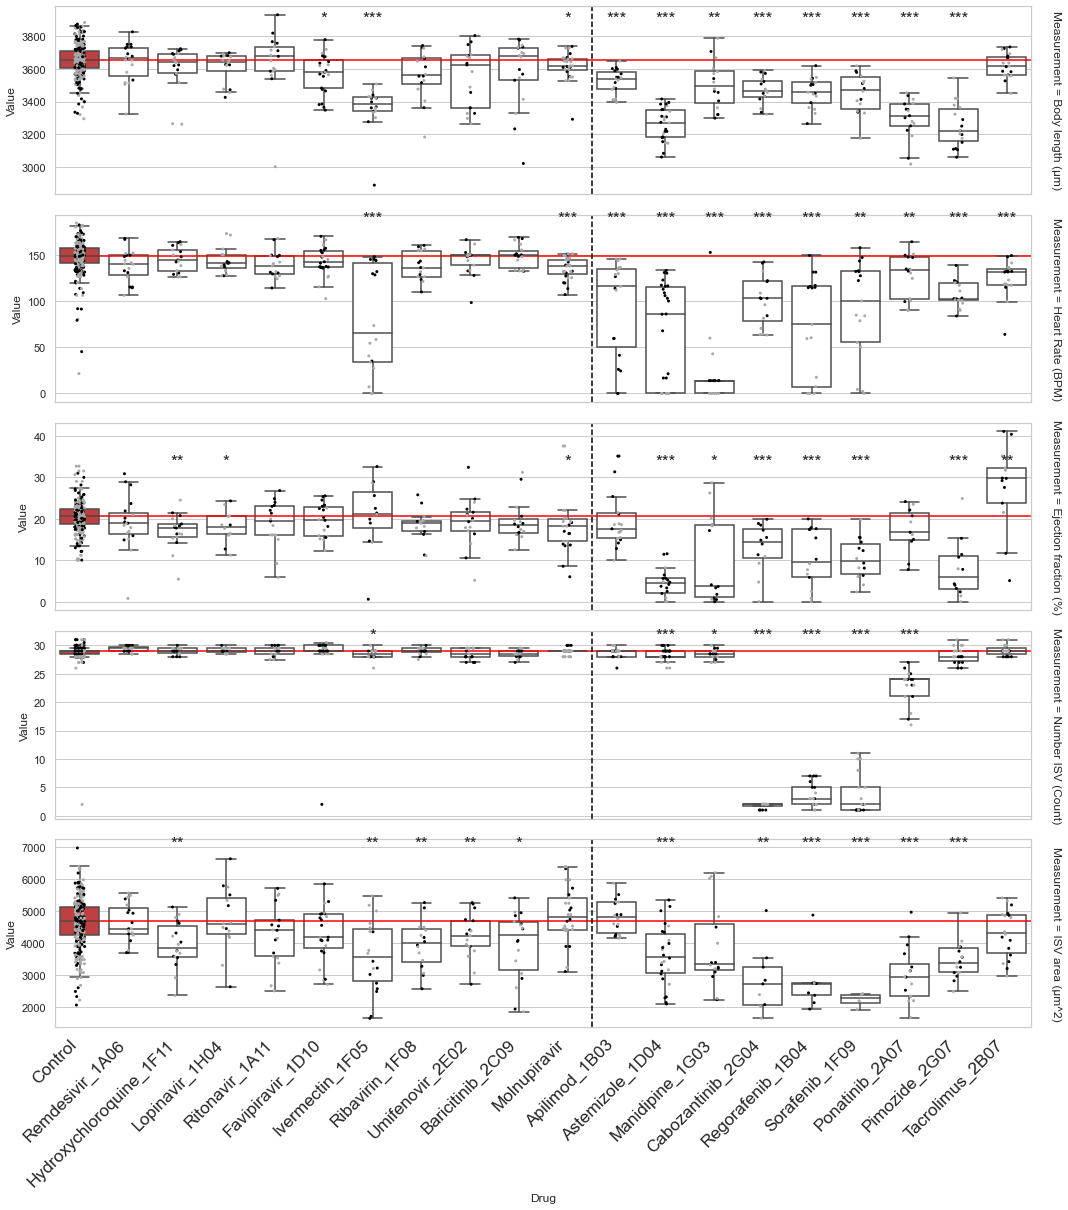

In [10]:
plt.figure(figsize=(20,40))
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(df_covid_plot,row="Measurement",sharey=False,row_order=measurement,height=3,aspect=5,margin_titles=True,legend_out=True,despine=False)
g.map_dataframe(sns.stripplot, x="Drug",y="Value", hue="Repeat",palette=["black","darkgrey"],size=3,order=listdrugs)
g.map_dataframe(sns.boxplot, x="Drug",hue="Drug",y="Value",palette=cdict,fliersize=0,dodge=False,order=listdrugs,saturation=0.5)

g.refline(x=10.5,color='0')
for ax,rowname in zip(g.axes.flat,g.row_names):
    y_control = df_covid_plot[(df_covid_plot["Drug"]=="Control") & (df_covid_plot["Measurement"]==rowname)]["Value"]
    ax.hlines(xmin=0, y = y_control.median(), xmax=19.5,color="red")
    
    [ax.text(x = num, y = y_control.max(), s = stars, size = 'x-large', ha='center') for num,stars in enumerate(df_sign_covid_T.loc[rowname]) if stars != "ns"]


plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);

plt.savefig("./graphs/FigS4/Morphology_Selection_Boxplot_FacetGrid.pdf")

# Batch correction with the median of the "experiment" control, corrected to the median of all controls

In [20]:
df_dv = pd.read_excel("./tables/2022-08-08_Behavior_Assay_Collected_Measurements_median.xlsx").drop("Unnamed: 0",axis=1)

collist2 = list(df_dv.reset_index().columns)

df_standardized2 = ana.standardize_globalMedian(df_dv ,collist2, "Control", ["Concentration (µM)","Well"]).reset_index()
df_standardized2 = df_standardized2[(df_standardized2["Concentration (µM)"]==1.0) | (df_standardized2["Drug"] == "Apilimod_1B03")| (df_standardized2["Drug"] == "Ivermectin_1F05")| (df_standardized2["Drug"] == "Niclosamide_1A02")]
df_standardized2 = df_standardized2[~((df_standardized2["Concentration (µM)"]==1.0) & (df_standardized2["Drug"] == "Apilimod_1B03"))]

# Assign repeated experiments

In [23]:

for i in df_standardized2["Drug"].unique():
 
    ids = df_standardized2.reset_index().set_index("Drug").loc[i]["Experiment ID"]
    
    
    if type(ids) == pd.Series:
        ids = ids.unique()

    for rep,x in  enumerate(ids):
        df_standardized2 = df_standardized2.reset_index().set_index(["Experiment ID","Drug"])
        df_standardized2["Replicate"].loc[(x,i)] = rep
df_standardized2 = df_standardized2.reset_index()  

C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\IPython\core\interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Calculate statistics and scores

In [24]:
alldrugs = df_standardized2.Drug.unique()

measurement2 = ["Moving [s]|Accomodation","Velocity [mm/s]|Light", "Velocity [mm/s]|Dark","Velocity|Ratio Light/Dark"]

df_mannwhitney2 = ana.calculate_stats(df_standardized2, "mannWhitney", alldrugs, measurement2)
df_effsize2 = ana.calculate_stats(df_standardized2, "effSize" ,alldrugs, measurement2)
df_deltamed2 = ana.calculate_stats(df_standardized2, "deltaMedian", alldrugs, measurement2)

df_multiscore2 = df_mannwhitney2.applymap(math.log10).abs() * df_effsize2.abs() * df_deltamed2

df_sign2 = ana.sign_stars(df_mannwhitney2)
df_sign_T2 = df_sign2.T

In [25]:
listdrugs = ["Control","Remdesivir_1A06","Hydroxychloroquine_1F11","Lopinavir_1H04","Ritonavir_1A11","Favipiravir_1D10","Ivermectin_1F05","Ribavirin_1F08","Umifenovir_2E02","Baricitinib_2C09","Molnupiravir",
             "Apilimod_1B03","Astemizole_1D04","Manidipine_1G03","Cabozantinib_2G04","Regorafenib_1B04","Sorafenib_1F09","Ponatinib_2A07","Pimozide_2G07","Tacrolimus_2B07"]
cdict2  = {i: "white" if i != "Control" else "red" for i in listdrugs}
df_covid2 = df_standardized2.set_index("Drug").loc[listdrugs].reset_index()
df_sign_T2 = df_sign2.loc[listdrugs].T


measurement2 = ["Moving [s]|Accomodation","Velocity [mm/s]|Light", "Velocity [mm/s]|Dark","Velocity|Ratio Light/Dark"]

df_covid_plot2 = df_covid2.pivot_table(index=["Drug","Replicate","index"],values=measurement2).stack().reset_index().drop("index",axis=1)
df_covid_plot2.columns = ["Drug","Repeat","Measurement","Value"]


# Fig. S5: Behavior assay boxplot wit data points 

<Figure size 1440x2880 with 0 Axes>

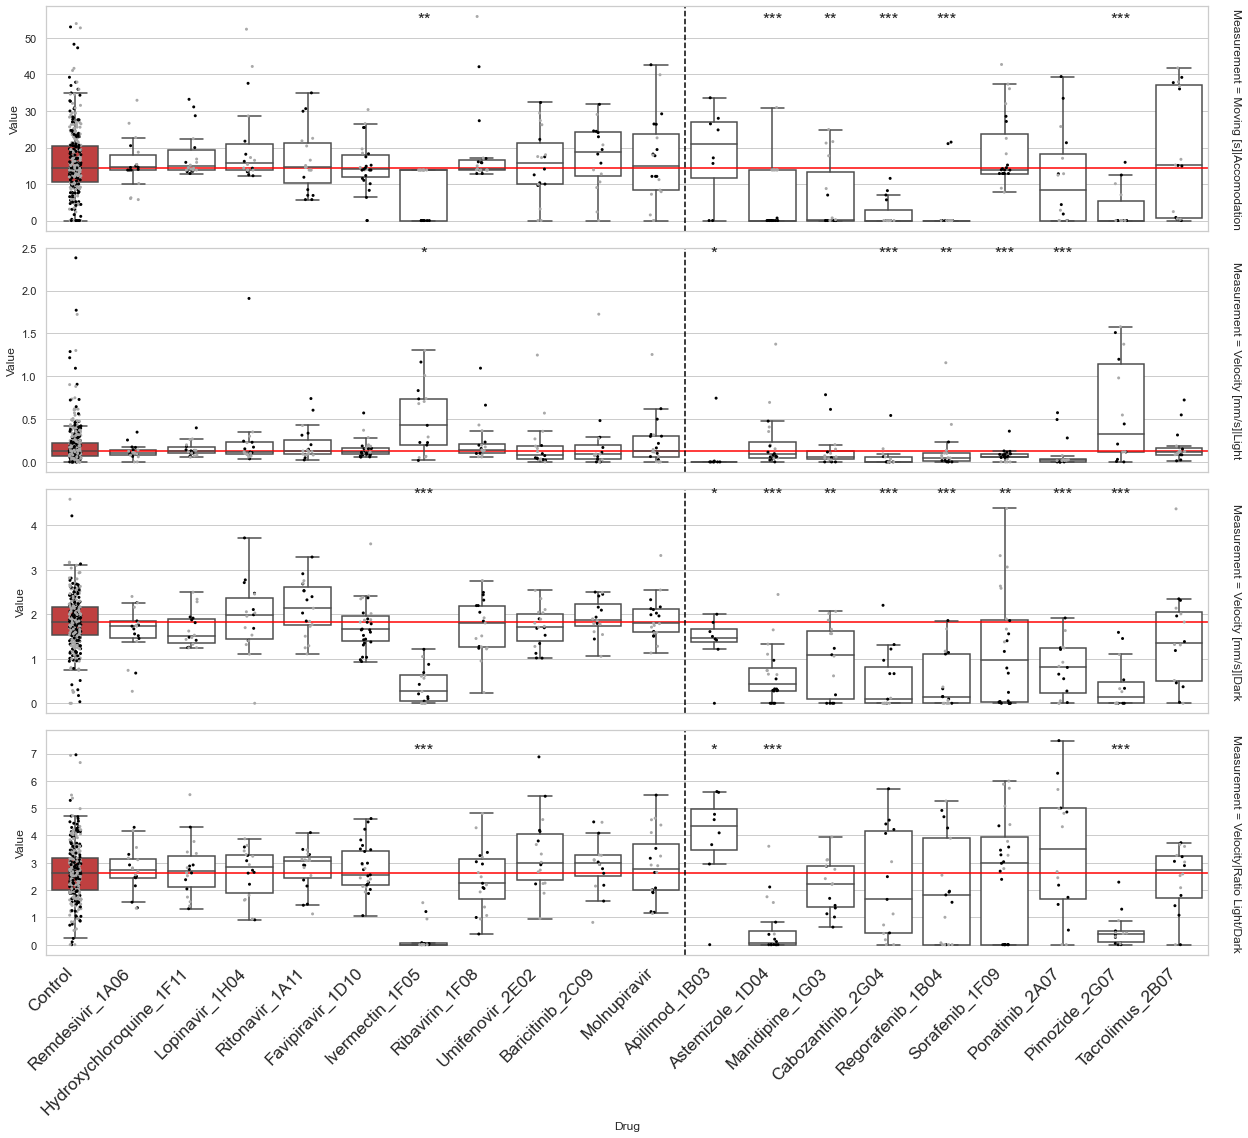

In [26]:
plt.figure(figsize=(20,40))
sns.set_context("paper")
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(df_covid_plot2,row="Measurement",sharey=False,row_order=measurement2,height=3.5,aspect=5,margin_titles=True,legend_out=True,despine=False)
g.map_dataframe(sns.stripplot, x="Drug",y="Value", hue="Repeat",palette=["black","darkgrey"],size=3,order=listdrugs)
g.map_dataframe(sns.boxplot, x="Drug",hue="Drug",y="Value",palette=cdict,fliersize=0,dodge=False,order=listdrugs,saturation=0.5)

g.refline(x=10.5,color='0')
for ax,rowname in zip(g.axes.flat,g.row_names):
    y_control2 = df_covid_plot2[(df_covid_plot2["Drug"]=="Control") & (df_covid_plot2["Measurement"]==rowname)]["Value"]
    ax.hlines(xmin=0, y = y_control2.median(), xmax=19.5,color="red")
    
    [ax.text(x = num, y = y_control2.max(), s = stars, size = 'x-large', ha='center') for num,stars in enumerate(df_sign_T2.loc[rowname]) if stars != "ns"]
    #if rowname == "Velocity|Ratio Dark-Bright":
    #    ax.set_yscale('log')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);

plt.savefig("./graphs/FigS5/Behavior_Selection_Boxplot_FacetGrid.pdf")

# Fig. 2 Heatmap Overview

In [178]:
df_all_merge = pd.concat([df_multiscore,df_multiscore2],axis=1)
df_all_mannwhitney_merge = pd.concat([df_mannwhitney,df_mannwhitney2],axis=1)
annotation_all = ana.sign_stars(df_all_mannwhitney_merge)
annotation_binary_all = annotation_all == "ns"

In [239]:
# Autofluorescence of Doxorubicin altered the autofocus and thus the heart was not fully in focus and the calculated ejection fraction incorrect 
df_all_merge.loc["Doxorubicin_2A05","Ejection fraction (%)"] = np.nan
df_all_merge_significant = df_all_merge[~annotation_binary_all].fillna(value=0)

df_g = ana.negpos_scale(df_all_merge_significant.copy())#negpos_scale(df_all_merge_significant.copy())

group_all0 = df_g[(df_g == 0).all(axis=1)]
group_all0["Group"] = "No effect"
df_group = pd.concat([pd.DataFrame(df_g[(df_g != 0).any(axis=1)].abs().idxmax(axis=1),columns=["Group"]),pd.DataFrame(group_all0["Group"])],axis=0, join='outer')

C:\Users\aernst\AppData\Local\Temp/ipykernel_16112/2111208921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_all0["Group"] = "No effect"


In [183]:
df_g

,Body length (µm),Heart Rate (BPM),Ejection fraction (%),Number ISV (Count),ISV area (µm^2),Moving [s]|Accomodation,Velocity [mm/s]|Light,Velocity [mm/s]|Dark,Velocity|Ratio Light/Dark
GSK-369796_1C03,0.000000,-0.102928,0.146108,-0.04959,0.0,0.0,0.000000,0.000000,0.000000
Daclatasvir_1C04,0.000000,-0.199853,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
Lonafarnib_1C05,0.000000,-0.245995,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
Itraconazole_1C06,0.000000,-0.477220,0.000000,0.00000,0.0,0.0,-0.598845,0.000000,0.000000
GSK 983_1C07,0.000000,-0.085114,0.000000,0.00000,0.0,0.0,-0.195179,0.000000,0.255847
...,...,...,...,...,...,...,...,...,...
Ruxolitinib_1B11,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
Niclosamide_1A02,-0.148128,-0.189194,0.000000,0.00000,0.0,0.0,-1.517038,0.000000,0.964464
Apilimod_1B03,-0.278984,-2.104048,0.000000,0.00000,0.0,0.0,-1.060644,-0.292927,1.261181
Molnupiravir,-0.007477,-0.241445,-0.065034,0.00000,0.0,0.0,0.000000,0.000000,0.000000


In [240]:
df_cat = pd.concat([df_group,df_g],axis=1).sort_values("Group").reset_index().rename(columns={"index":"Drug"}).set_index(["Group","Drug"])
ordered_measurements = ['Body length (µm)',['Heart Rate (BPM)','Ejection fraction (%)'],['Number ISV (Count)','ISV area (µm^2)'],['Velocity [mm/s]|Dark','Velocity [mm/s]|Light','Moving [s]|Accomodation','Velocity|Ratio Light/Dark'],'No effect']

df_cat= df_cat.reset_index().set_index("Drug")

df_cat.index = [i.split("_")[0] for i in df_cat.index]
df_cat= df_cat.reset_index().rename(columns={"index":"Drug"}).set_index(["Group","Drug"])

Body length (µm) False
['Heart Rate (BPM)', 'Ejection fraction (%)'] True
['Number ISV (Count)', 'ISV area (µm^2)'] True
['Velocity [mm/s]|Dark', 'Velocity [mm/s]|Light', 'Moving [s]|Accomodation', 'Velocity|Ratio Light/Dark'] True


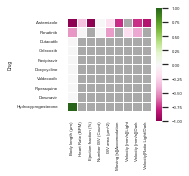

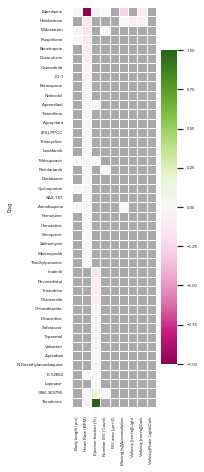

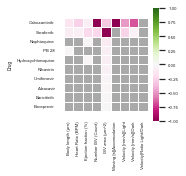

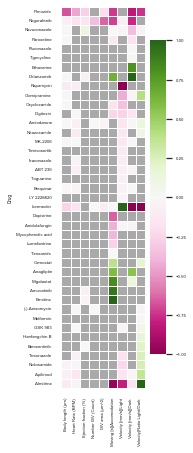

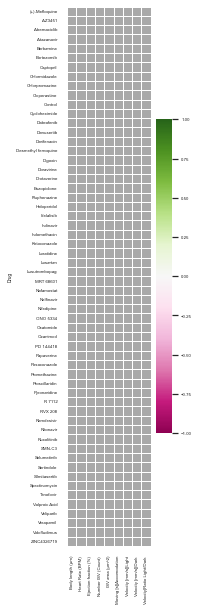

In [241]:
#plt.figure(figsize=(50,50))

#fig, axs = plt.subplots(2, 3, sharex=True, sharey=False,figsize=(50,50))

# creating a dictionary
font = {'size': 1}
scale= 4.8
plt.rc('font', **font)
# using rc function
sns.set(font_scale=0.4)

for i,m in enumerate(ordered_measurements):
    
    if m != "No effect":
        print(m, type(m) is list)
        if type(m) is list:
            df_pl = pd.DataFrame([])
            for ms in m:
                df_pre = df_cat.loc[ms].sort_values(ms)
                df_pl  = pd.concat([df_pl, df_pre],axis=0)
                
        else:
            df_pl = df_cat.loc[m].sort_values(m)
        plt.figure(figsize=(df_pl.shape[1]/scale,df_pl.shape[0]/scale))
        plt.rc('font', **font)
        sns.heatmap(df_pl,center=0,linewidths=0.5,cmap='PiYG',mask=(df_pl==0),fmt = '',square=True,vmin=-1,vmax=1).set_facecolor("darkgrey")
        
        plt.savefig("./graphs/Fig2/Heatmap_EffectGrouped_{}.pdf".format(i))
    
    else:
        plt.figure(figsize=(df_cat.loc[m].shape[1]/scale,df_cat.loc[m].shape[0]/scale))
        plt.rc('font', **font)
        
        sns.heatmap(df_cat.loc[m].sort_index(),center=0,linewidths=0.5,cmap='PiYG', mask=(df_cat.loc[m].sort_index()==0), fmt = '',square=True,vmin=-1,vmax=1).set_facecolor("darkgrey")
        plt.savefig("./graphs/Fig2/Heatmap_EffectGrouped_{}.pdf".format(i))
    

# Fig. 5 Heatmap Selected Drugs

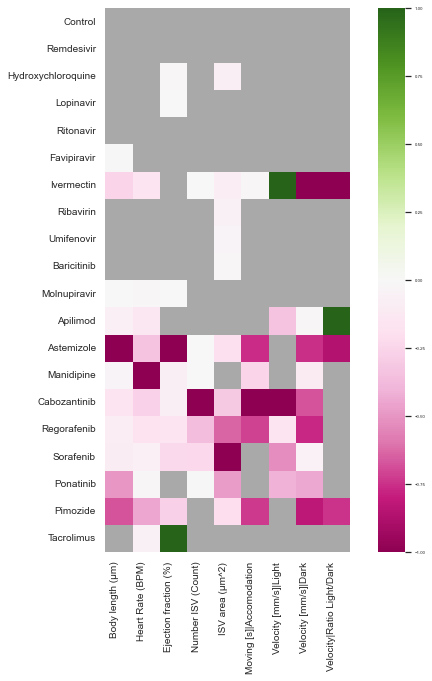

In [244]:
df_merge = pd.concat([df_multiscore,df_multiscore2],axis=1).loc[listdrugs]
df_merge.index = [i.split("_")[0] for i in df_merge.index]

df_mannwhitney_merge = pd.concat([df_mannwhitney,df_mannwhitney2],axis=1).loc[listdrugs]
df_mannwhitney_merge.index = [i.split("_")[0] for i in df_mannwhitney_merge.index]

annotation = ana.sign_stars(df_mannwhitney_merge)
annotation_binary = annotation == "ns"
annotation_binary.index = [i.split("_")[0] for i in annotation_binary.index]


plt.figure(figsize=(10,10))

#colormap.set_bad("black") 
sns.heatmap(ana.negpos_scale(df_merge),mask= annotation_binary,center=0,cmap='PiYG',fmt = '',square=True,vmin=-1,vmax=1).set_facecolor("darkgrey")
plt.xticks(
    rotation = 90, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 10  
);
plt.yticks(
    fontsize = 10  
);

plt.savefig("./graphs/Fig5/Selection_Heatmap.pdf")
plt.show()

In [221]:
df_covid_heart_development = pd.read_excel("./tables/2022-07-12_CovidDrugScreen_Results_Literature_intersection.xlsx",header=[0,1],skiprows=0).drop(0).drop(("Unnamed: 0_level_0", 
"Unnamed: 0_level_1"),axis=1)

In [217]:
#df_covid_heart_development.columns = [eval(x) if "(" in x else x for x in df_covid_heart_development.columns]

In [225]:
df_covid_counts 

index  Origin                                            \
          Drug ID Plate ID Well ID                      Tag   
0      66    66.0      1.0     G07         Terconazole_1G07   
1     149   149.0      2.0     G10          Valdecoxib_2G10   
2      22    22.0      1.0     C03          GSK-369796_1C03   
3     102   102.0      2.0     C03        Oxyclozanide_2C03   
4      26    26.0      1.0     C07             GSK 983_1C07   
..    ...     ...      ...     ...                      ...   
156    39    39.0      1.0     D10         Favipiravir_1D10   
157    73    73.0      1.0     H04           Lopinavir_1H04   
158    10    10.0      1.0     A11           Ritonavir_1A11   
159     5     5.0      1.0     A06          Remdesivir_1A06   
160    60    60.0      1.0     F11  Hydroxychloroquine_1F11   

                                             \
           TRIVIAL_NAME       MODIFIED_NAME   
0           Terconazole         Terconazole   
1            Valdecoxib          Valdecoxib   
2            GSK-369796          GSK-369796   
3          Oxyclozanide        Oxyclozanide   
4               GSK 983              GSK983   
..                  ...                 ...   
156         Favipiravir         Favipiravir   
157           Lopinavir           Lopinavir   
158           Ritonavir           Ritonavir   
159          Remdesivir          Remdesivir   
160  Hydroxychloroquine  Hydroxychloroquine   

                                                            No  \
                                              SYNONYMS   Count   
0    ['Terconazole', 'terconazole', '67915-31-5', '...   257.0   
1    ['Valdecoxib', 'Valdecoxib', '181695-72-7', 'B...   557.0   
2    ['GSK-369796', 'N-tert-butyl isoquine', 'GSK36...     5.0   
3    ['Oxyclozanide', 'Oxyclozanide', '2277-92-1', ...   126.0   
4    ['GSK983', 'GSK983', '827591-02-6', '(R)-N-(6-...     6.0   
..                                                 ...     ...   
156  ['Favipiravir', 'Favipiravir', '259793-96-9', ...  1113.0   
157  ['Lopinavir', 'Lopinavir', '192725-17-0', 'ABT...  4223.0   
158  ['Ritonavir', 'ritonavir', '155213-67-5', 'Nor...  8642.0   
159  ['Remdesivir', '1809249-37-3', '3QKI37EEHE', '...  2877.0   
160  ['Hydroxychloroquine', 'hydroxychloroquine', '...  9591.0   

                                                       Covid-19  \
                                                   PID    Count   
0    ['35561435', '35335847', '35136875', '34726986...      0.0   
1    ['35685617', '35358477', '34951369', '34919887...      0.0   
2    ['29126722', '27889529', '19284751', '19222165...      0.0   
3    ['35797943', '35535471', '35468823', '35256121...      0.0   
4    ['32442424', '31420268', '30144461', '29294299...      0.0   
..                                                 ...      ...   
156  ['35816544', '35814322', '35812721', '35812166...    762.0   
157  ['35812140', '35811931', '35799933', '35796443...   1259.0   
158  ['35812140', '35811982', '35806297', '35804970...   1287.0   
159  ['35817072', '35816544', '35814322', '35807123...   2764.0   
160  ['35814626', '35814322', '35810379', '35810325...   3446.0   

                                                         heart  \
                                                   PID   Count   
0                                                   []     2.0   
1                                                   []   150.0   
2                                                   []     0.0   
3                                                   []     1.0   
4                                                   []     0.0   
..                                                 ...     ...   
156  ['35814322', '35812721', '35812166', '35780295...    72.0   
157  ['35811931', '35799933', '35796443', '35777878...   317.0   
158  ['35811982', '35803465', '35801839', '35792281...   521.0   
159  ['35817072', '35814322', '35807123', '35807058...   280.0   
160  ['35814322', '35808662', '35799756', '357923

In [234]:
df_covid_counts = df_covid_heart_development.sort_values((    'Covid-19',         'Count'), ascending=False)

df_covid_counts = df_covid_counts.reset_index()
df_covid_counts = df_covid_counts.set_index(("Origin","TRIVIAL_NAME"))[[(      'No',         'Count'),('Covid-19',         'Count'),(   'heart',         'Count'),(  'embryo',         'Count')]]

#df_covid_counts_melt = df_covid_counts.melt(id_vars="TRIVIAL_NAME", value_vars=list(df_covid_counts.columns[1:]), var_name=["Context"], value_name='Count', ignore_index=True)

In [236]:
df_covid_counts[:15]

,No,Covid-19,heart,embryo
,Count,Count,Count,Count
"(Origin, TRIVIAL_NAME)",,,,
Hydroxychloroquine,9591.0,3446.0,1227.0,507.0
Remdesivir,2877.0,2764.0,280.0,75.0
Ritonavir,8642.0,1287.0,521.0,359.0
Lopinavir,4223.0,1259.0,317.0,234.0
Favipiravir,1113.0,762.0,72.0,18.0
Ivermectin,9580.0,486.0,128.0,214.0
Ribavirin,17812.0,300.0,386.0,243.0
Baricitinib,902.0,284.0,67.0,12.0


In [ ]:
df_collect.to_csv("E:/Data_Drug_Screening_CovidBox/Master_Table/CovidDrugScreen_Results_MeanActivity_Daniovision.csv")

In [ ]:
pd.read_csv("E:/Data_Drug_Screening_CovidBox/Master_Table/CovidDrugScreen_Results_MeanActivity_Daniovision.csv").set_index(["Experiment ID","Drug"])

In [ ]:
plt.figure(figsize=(30,10))
sns.lineplot(data = df_bin1_plot, x="Bin [1 sec]", y="Velocity [mm/s]", hue="Drug")

plt.xticks(
    rotation = 90, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 10  
);

plt.yticks(
    fontsize = 10  
);


In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
fig = px.line(df_collect.loc["0"].reset_index(), x="Bin [1 sec]", y="Velocity [mm/s]", color='Drug')
fig.show()
